# Introduction

This notebook presents how to train CIFAR-10 dataset on the pretrained VGG19 model. I borrow VGG19 included in tensornets package whose github repo is [here](https://github.com/taehoonlee/tensornets). Also, I will try with the different [implementation](https://github.com/machrisaa/tensorflow-vgg) of the same VGG19 architecture after done with tensornets package. 

The main purpose is to understand the concept of transfer learning and experience with the actual usage. I previously made an notebook to build classical CNN model to train CIFAR-10 dataset, so I can compare between the state of the art CNN model and the very basic CNN model. I am expecting VGG19 will outperform easily. 

# Package Dependency

Before diving in, let's install required packages. If your system doesn't have these listed below, please run the code cell below.

In [ ]:
!pip install h5py
!pip install scipy

# scikit-image package for transforming 
# size of CIFAR-10 image into the input size for VGG19 model.
!pip install scikit-image

# tqdm package for adding progress bar like UI
!pip install tqdm

# Cython package is required to install tensornets
!pip install Cython

In [ ]:
# this will install tensornets package automatically.
# However, if you are on Windows and encountering Visual Studio Build Tool thing, please install it beforehand
!pip install git+https://github.com/taehoonlee/tensornets.git

# Importing libraries

In [2]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm 
import tarfile
import pickle
import numpy as np
import matplotlib.pyplot as plt

import skimage
import skimage.io
import skimage.transform

import tensorflow as tf
import tensornets as nets

C:\Users\user\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# GPU configuration for Tensorflow

If you have a very high-end GPU running on your machine, you can skip this section. I needed this configuration, and I have run the training with NVIDIA GTX 1080Ti

In [ ]:
config = tf.ConfigProto(allow_soft_placement=True)

# "Best-fit with coalescing" algorithm for memory allocation
config.gpu_options.allocator_type = 'BFC'
config.gpu_options.per_process_gpu_memory_fraction = 0.80

# CIFAR-10 Dataset Preparation

This is the same step as described in my other github [repo](https://github.com/deep-diver/CIFAR10-img-classification-tensorflow). If you are more interested in this step, please read the detailed explanation from the link. Otherwise, you can skip to the next section.

## Download CIFAR-10 Dataset

In [10]:
cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DownloadProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

""" 
    check if the data (zip) file is already downloaded
    if not, download it from "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz" and save as cifar-10-python.tar.gz
"""
if not isfile('cifar-10-python.tar.gz'):
    with DownloadProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()

## load raw data and reshape the input images

In [8]:
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
        
    return features, labels

## one hot encoding method for label data

In [7]:
def one_hot_encode(x):
    """
        argument
            - x: a list of labels
        return
            - one hot encoding matrix (number of labels, number of class)
    """
    encoded = np.zeros((len(x), 10))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    
    return encoded

## save the modified input(feature) and labels 

In [18]:
def _preprocess_and_save(one_hot_encode, features, labels, filename):
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, one_hot_encode):
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        
        # find index to be the point as validation data in the whole dataset of the batch (10%)
        index_of_validation = int(len(features) * 0.1)

        # preprocess the 90% of the whole dataset of the batch
        # - normalize the features
        # - one_hot_encode the lables
        # - save in a new file named, "preprocess_batch_" + batch_number
        # - each file for each batch
        _preprocess_and_save(one_hot_encode,
                             features[:-index_of_validation], labels[:-index_of_validation], 
                             'preprocess_batch_' + str(batch_i) + '.p')

        # unlike the training dataset, validation dataset will be added through all batch dataset
        # - take 10% of the whold dataset of the batch
        # - add them into a list of
        #   - valid_features
        #   - valid_labels
        valid_features.extend(features[-index_of_validation:])
        valid_labels.extend(labels[-index_of_validation:])

    # preprocess the all stacked validation dataset
    _preprocess_and_save(one_hot_encode,
                         np.array(valid_features), np.array(valid_labels),
                         'preprocess_validation.p')

    # load the test dataset
    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # preprocess the testing data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all testing data
    _preprocess_and_save(one_hot_encode,
                         np.array(test_features), np.array(test_labels),
                         'preprocess_testing.p')

In [19]:
preprocess_and_save_data(cifar10_dataset_folder_path, one_hot_encode)

# Traning the model for CIFAR-10

## Load data

In [3]:
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Define input (feature) and output (label)

<img src="https://lihan.me/assets/images/vgg-hero-cover.jpg"/>

<p style="text-align:center;">
__VGG19 Architecture__
</p>
<p style="text-align:center;">
(borrowed from [vgg19-caltech101-classification](https://lihan.me/2018/01/vgg19-caltech101-classification/))
</p>

VGG models described in the [original paper](https://arxiv.org/pdf/1409.1556.pdf) are trained with images whose size is 224x224x3. This can not be changed, so the input image for the transfer learning task should have the same image size. For the output, CIFAR-10 contains 10 categorical image data which makes the output size 10 as well.

In [59]:
x = tf.placeholder(tf.float32, shape=(None, 224, 224, 3), name='input_x')
y = tf.placeholder(tf.float32, shape=(None, 10), name='output_y')

## Hyper-parameters

- You don't need many epochs since this is transfer learning.
- you can increase the batch size if you have a very high-end GPU running. 32 is the maximum value I could try with NVIDIA GTX 1080Ti

In [60]:
learning_rate = 0.00001
epochs = 7
batch_size = 32

## Load VGG19 model, Define loss, train, and accuracy tensor/Operation

The first step is to predefined VGG19 model. 
- if you want to run the model as it is, just pass the input placeholder.
- if you want to train on your own image dataset, set is_training=True, and classes=# of class

nets.VGG19 returns the final layer of the VGG19 which is softmax. If you know, tensorflow comes with tf.nn.softmax_cross_entropy_with_logits function, and this applies softmax and cross entropy together. However, nets.VGG19 returns the layer already applied with softmax, so we need only cross entropy. That can be achieved by tf.losses.softmax_cross_entropy function.

In your choice, you can choose your favorite optimizer. I am going to use Adam optimizer since it is known to work moderate for most of deep learning problems.

In [61]:
logits = nets.VGG19(x, is_training=True, classes=10)
model = tf.identity(logits, name='logits')

loss = tf.losses.softmax_cross_entropy(y, logits)
train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

correct_pred = tf.equal(tf.argmax(model, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

## print outputs of each layer

- nets.VGG19 comes with handy methods, 'print_outputs', and 'get_outputs'. 
- With 'print_outputs' method, you can print out how this model is constructed. You could compare the actual implementation and the conceptual model. 
- With 'get_outputs', you can actually access each layer's output. In this way, you could modify the model in your own way like inserting new layer or removing the existing ones.
- if you want to know the more compact to way to navigate the layers, you could g

In [62]:
logits.print_outputs()

Scope: vgg19
conv1/1/conv/BiasAdd:0 (?, 224, 224, 64)
conv1/1/Relu:0 (?, 224, 224, 64)
conv1/2/conv/BiasAdd:0 (?, 224, 224, 64)
conv1/2/Relu:0 (?, 224, 224, 64)
conv1/pool/MaxPool:0 (?, 112, 112, 64)
conv2/1/conv/BiasAdd:0 (?, 112, 112, 128)
conv2/1/Relu:0 (?, 112, 112, 128)
conv2/2/conv/BiasAdd:0 (?, 112, 112, 128)
conv2/2/Relu:0 (?, 112, 112, 128)
conv2/pool/MaxPool:0 (?, 56, 56, 128)
conv3/1/conv/BiasAdd:0 (?, 56, 56, 256)
conv3/1/Relu:0 (?, 56, 56, 256)
conv3/2/conv/BiasAdd:0 (?, 56, 56, 256)
conv3/2/Relu:0 (?, 56, 56, 256)
conv3/3/conv/BiasAdd:0 (?, 56, 56, 256)
conv3/3/Relu:0 (?, 56, 56, 256)
conv3/4/conv/BiasAdd:0 (?, 56, 56, 256)
conv3/4/Relu:0 (?, 56, 56, 256)
conv3/pool/MaxPool:0 (?, 28, 28, 256)
conv4/1/conv/BiasAdd:0 (?, 28, 28, 512)
conv4/1/Relu:0 (?, 28, 28, 512)
conv4/2/conv/BiasAdd:0 (?, 28, 28, 512)
conv4/2/Relu:0 (?, 28, 28, 512)
conv4/3/conv/BiasAdd:0 (?, 28, 28, 512)
conv4/3/Relu:0 (?, 28, 28, 512)
conv4/4/conv/BiasAdd:0 (?, 28, 28, 512)
conv4/4/Relu:0 (?, 28, 28, 5

In [63]:
logits.print_summary()

Scope: vgg19
Total layers: 19
Total weights: 114
Total parameters: 418,833,630


## Get Batches

In [22]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

The size of each CIFAR-10 image is 32x32, and VGG19 takes input image sizes 224x224 which is incompatible. Each CIFAR-10 image should be resized so that it can be fed into the VGG19 model. 

skimage.transform.resize function does the trick. It takes parameters..
- takes a numpy matrix representation of an image
- image size to be transformed


In [7]:
def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))
    
    tmpFeatures = []
    
    for feature in features:
        tmpFeature = skimage.transform.resize(feature, (224, 224), mode='constant')
        tmpFeatures.append(tmpFeature)

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(tmpFeatures, labels, batch_size)

## Get inputs for validation

The same process from load_preprocess_training_batch is applied.

In [8]:
tmpValidFeatures = []

for feature in valid_features:
    tmpValidFeature = skimage.transform.resize(feature, (224, 224), mode='constant')
    tmpValidFeatures.append(tmpValidFeature)
    
tmpValidFeatures = np.array(tmpValidFeatures)

5,000 images in a batch is huge to be trained. If you have a very high-end GPU card, you can try all images at once, but I will go with batch validation, then calculate the mean of them. 

In [9]:
print(tmpValidFeatures.shape)

(5000, 224, 224, 3)


## Training

In [12]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:    
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    print('global_variables_initializer ... done ...')
    sess.run(logits.pretrained())
    print('model.pretrained ... done ... ')    
    
    # Training cycle
    print('starting training ... ')
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                sess.run(train, {x: batch_features, y: batch_labels})
                
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            
            # calculate the mean accuracy over all validation dataset
            valid_acc = 0
            for batch_valid_features, batch_valid_labels in batch_features_labels(tmpValidFeatures, valid_labels, batch_size):
                valid_acc += sess.run(accuracy, {x:batch_valid_features, y:batch_valid_labels})
            
            tmp_num = tmpValidFeatures.shape[0]/batch_size
            print('Validation Accuracy: {:.6f}'.format(valid_acc/tmp_num))
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
global_variables_initializer ... done ...
model.pretrained ... done ... 
starting training ... 
Epoch  1, CIFAR-10 Batch 1:  Validation Accuracy: 0.510000
Epoch  1, CIFAR-10 Batch 2:  Validation Accuracy: 0.719000
Epoch  1, CIFAR-10 Batch 3:  Validation Accuracy: 0.770200
Epoch  1, CIFAR-10 Batch 4:  Validation Accuracy: 0.814000
Epoch  1, CIFAR-10 Batch 5:  Validation Accuracy: 0.832000
Epoch  2, CIFAR-10 Batch 1:  Validation Accuracy: 0.841600
Epoch  2, CIFAR-10 Batch 2:  Validation Accuracy: 0.850000
Epoch  2, CIFAR-10 Batch 3:  Validation Accuracy: 0.868000
Epoch  2, CIFAR-10 Batch 4:  Validation Accuracy: 0.856600
Epoch  2, CIFAR-10 Batch 5:  Validation Accuracy: 0.857400
Epoch  3, CIFAR-10 Batch 1:  Validation Accuracy: 0.867600
Epoch  3, CIFAR-10 Batch 2:  Validation Accuracy: 0.874400
Epoch  3, CIFAR-10 Batch 3:  Validation Accuracy: 0.887600
Epoch  3, CIFAR-10 Batch 4:  Validation Accuracy: 0.867200
Epoch  3, CIFAR-10 Batch 5:  Validation Accuracy: 0.888400
Epoch  

# Testing the model over random sample images

## mapping label index to label name

In [3]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## display prediction results (match or not?)

In [56]:
from sklearn.preprocessing import LabelBinarizer

def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axs = plt.subplots(10, 2, figsize=(12,24))

    margin = 0.05
    ind = np.arange(n_classes)
    width = (1. - 2. * margin) / n_classes    
    
    for image_i, (feature, label_id, prediction) in enumerate(zip(features, label_ids, predictions)):
        correct_name = label_names[label_id]
        pred_name = label_names[np.argmax(prediction)]
        
        is_match = 'False'        
        
        if np.argmax(prediction) == label_id:
            is_match = 'True'
            
        predictions_array = []
        pred_names = []
        
        for index, pred_value in enumerate(prediction):
            tmp_pred_name = label_names[index]
            predictions_array.append({tmp_pred_name : pred_value})
            pred_names.append(tmp_pred_name)
        
        print('[{}] ground truth: {}, predicted result: {} | {}'.format(image_i, correct_name, pred_name, is_match))
        print('\t- {}\n'.format(predictions_array))
        
#         print('image_i: ', image_i)
#         print('axs: ', axs, ', axs len: ', len(axs))
        axs[image_i][0].imshow(feature)
        axs[image_i][0].set_title(pred_name)
        axs[image_i][0].set_axis_off()
        
        axs[image_i][1].barh(ind + margin, prediction, width)
        axs[image_i][1].set_yticks(ind + margin)
        axs[image_i][1].set_yticklabels(pred_names)
        
    plt.tight_layout()

## Load dataset for testing

In [20]:
test_features, test_labels = pickle.load(open('preprocess_testing.p', mode='rb'))
tmpFeatures = []

for feature in test_features:
    tmpFeature = skimage.transform.resize(feature, (224, 224), mode='constant')
    tmpFeatures.append(tmpFeature)

tmpFeatures = np.asarray(tmpFeatures)

## Testing 

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.917296974522293

[0] ground truth: dog, predicted result: dog | True
	- [{'airplane': 0.085336745}, {'automobile': 0.085336745}, {'bird': 0.085336745}, {'cat': 0.085336745}, {'deer': 0.085336745}, {'dog': 0.23196931}, {'frog': 0.085336745}, {'horse': 0.085336745}, {'ship': 0.085336745}, {'truck': 0.085336745}]

[1] ground truth: dog, predicted result: dog | True
	- [{'airplane': 0.085336745}, {'automobile': 0.085336745}, {'bird': 0.085336745}, {'cat': 0.085336745}, {'deer': 0.085336745}, {'dog': 0.23196931}, {'frog': 0.085336745}, {'horse': 0.085336745}, {'ship': 0.085336745}, {'truck': 0.085336745}]

[2] ground truth: deer, predicted result: deer | True
	- [{'airplane': 0.085336745}, {'automobile': 0.085336745}, {'bird': 0.08533677}, {'cat': 0.085336745}, {'deer': 0.23196924}, {'dog': 0.085336745}, {'frog': 0.085336745}, {'horse': 0.085336745}, {'ship': 0.085336745}, {'truck': 0.085336745}]

[3] groun

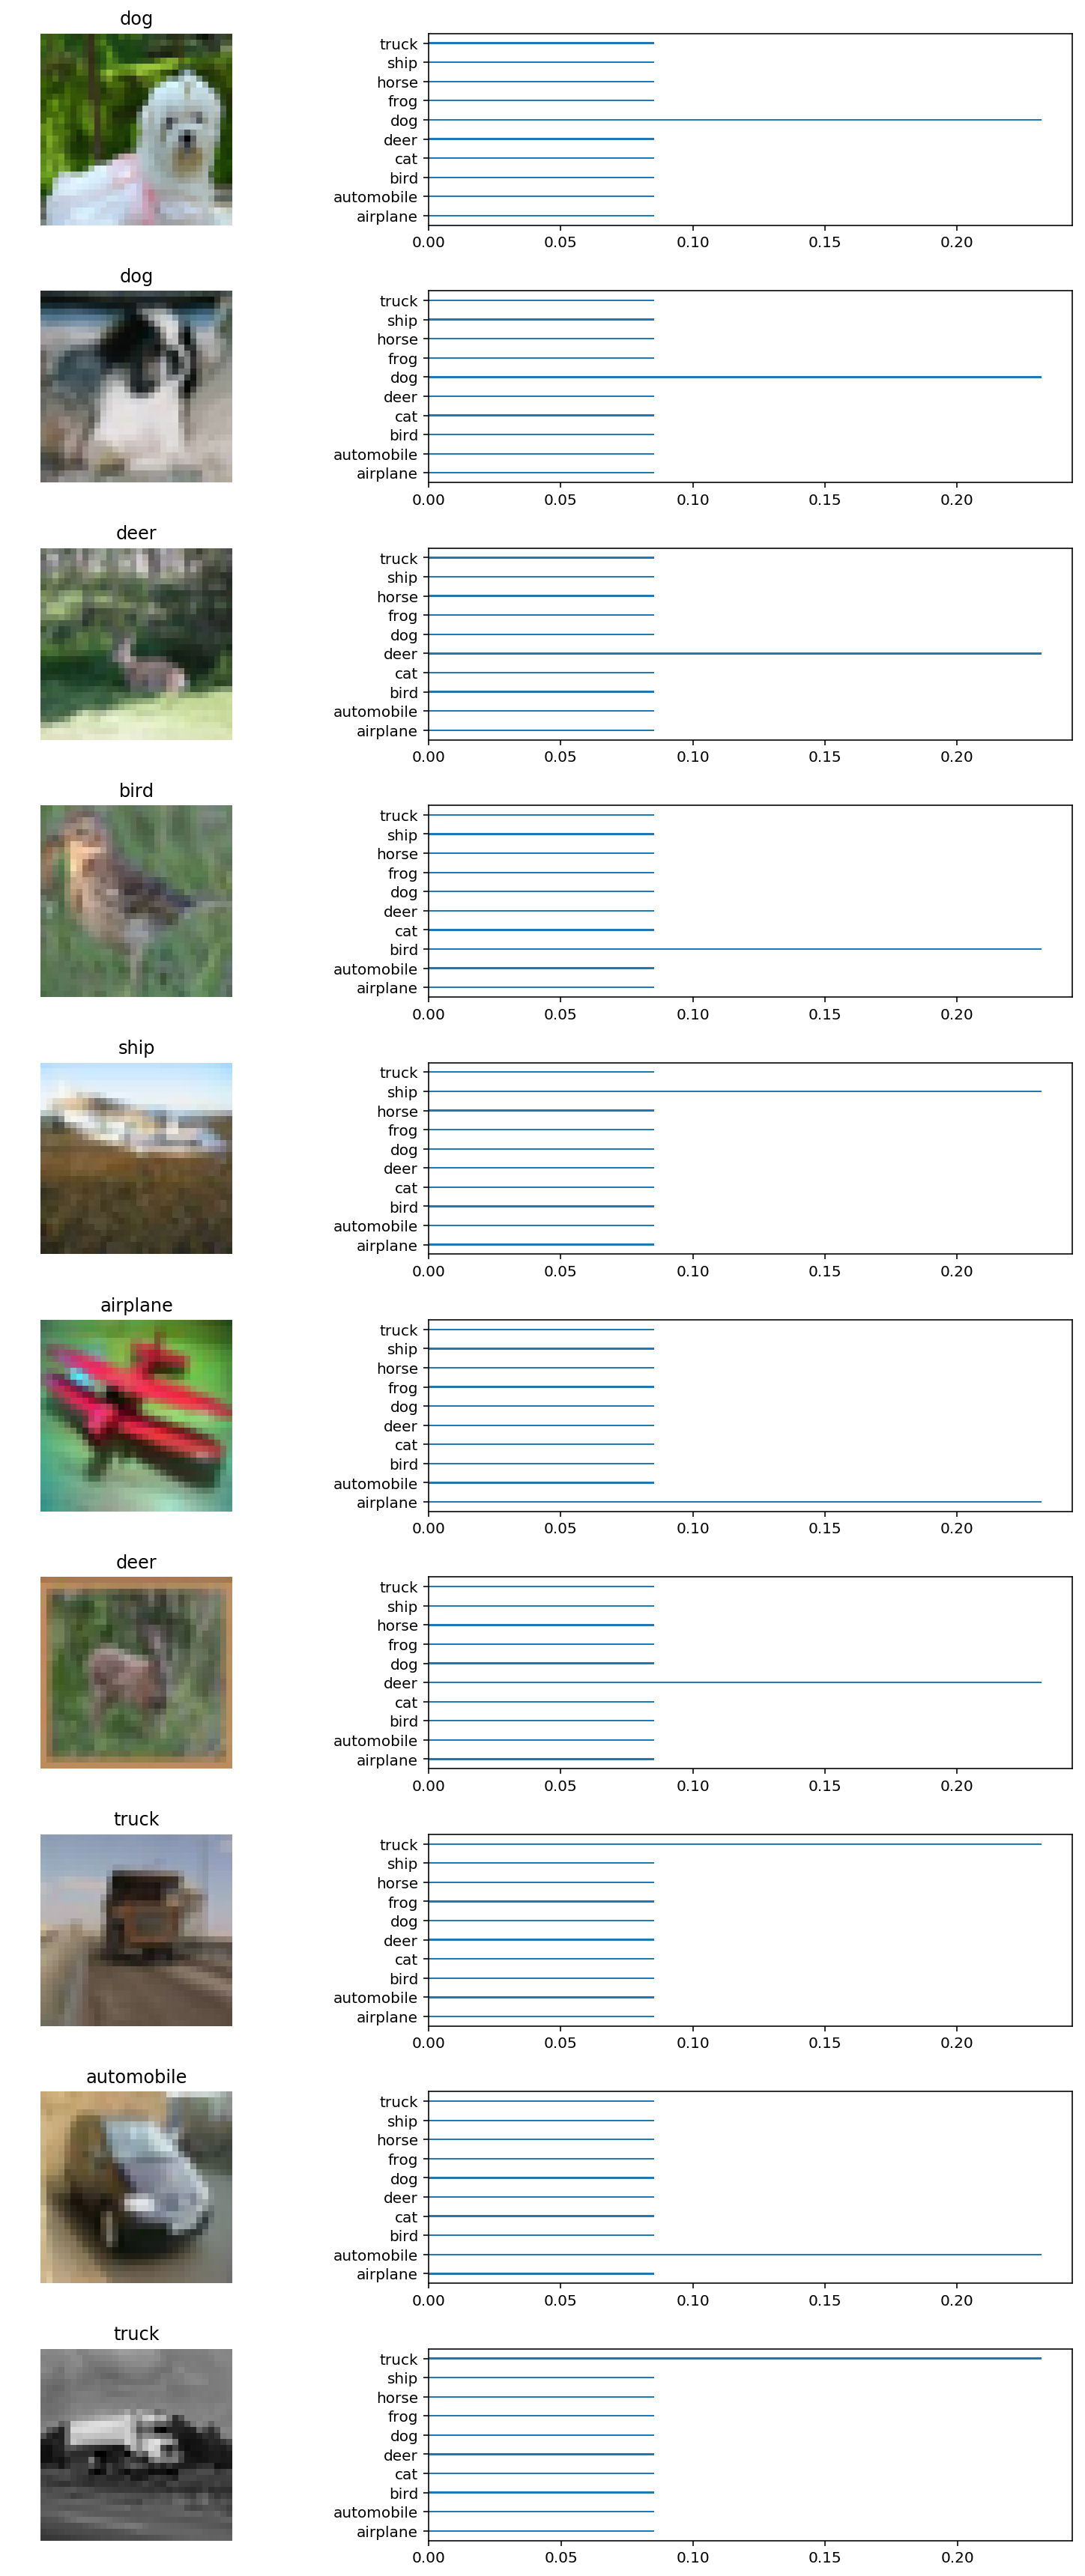

In [57]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import random

save_model_path = './image_classification'
batch_size = 64
n_samples = 10
top_n_predictions = 5

def test_model(tmpFeatures):
    loaded_graph = tf.Graph()
    
    with tf.Session(graph=loaded_graph) as sess:
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        loaded_x = loaded_graph.get_tensor_by_name('input_x:0')
        loaded_y = loaded_graph.get_tensor_by_name('output_y:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        for train_feature_batch, train_label_batch in batch_features_labels(tmpFeatures, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        
        tmpTestFeatures = []
    
        for feature in random_test_features:
            tmpFeature = skimage.transform.resize(feature, (224, 224), mode='constant')
            tmpTestFeatures.append(tmpFeature)
           
        random_test_predictions = sess.run(
            tf.nn.softmax(loaded_logits),
            feed_dict={loaded_x: tmpTestFeatures, loaded_y: random_test_labels})
        
        display_image_predictions(random_test_features, random_test_labels, random_test_predictions)

test_model(tmpFeatures)